In [1]:
import os,glob
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score,precision_score
from tqdm import tqdm
import scipy.io
from scipy.io import loadmat
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

import models

In [2]:
fname = "./data/heart_disease/processed_cleveland_data.csv"
column_names = ["age","sex","cp","trestbps","chol","fbs","restecg","thalach","exang","oldpeak","slope","ca","thal","num"]
data = pd.read_csv(fname,header=None,names=column_names)
data["num"] = np.where(data["num"]==0,0,1)
data = data.drop(np.where((data=='?').sum(axis=1)!=0)[0])
data = data.astype("float")
cont_cols = ["age","trestbps","chol","thalach","oldpeak"]
cat_binary_cols = ["sex","fbs","exang"]
# cat_cols = ["sex","cp","fbs","restecg","exang","slope"]
# cat_cols = ["sex","cp","fbs","restecg","exang","slope","ca","thal"]
cat_cols = ["cp","restecg","slope","ca","thal"]
data[cat_cols] =  data[cat_cols].astype("int")


In [3]:
data_processed = data[cont_cols].copy()

for column in cont_cols:
    if column=="age":
        age_min = data_processed[column].min()
        age_max = data_processed[column].max()
    data_processed[column] = (data_processed[column] - data_processed[column].min()) / (data_processed[column].max() - data_processed[column].min())

for cat_binary_col in cat_binary_cols:
    y = data[cat_binary_col]
    data_processed = pd.concat([data_processed, y], axis=1)

for cat_col in cat_cols:
    y = pd.get_dummies(data[cat_col], prefix=cat_col)
    data_processed = pd.concat([data_processed, y], axis=1)

data_processed = pd.concat([data_processed, data[["num"]]], axis=1)
data_processed = data_processed.astype("float")
# data_processed = data_processed.to_numpy()
# data_processed.shape
data_processed = shuffle(data_processed,random_state=42)
data_processed = data_processed.rename(dict(zip(list(data_processed.index),range(len(data_processed)))))
data_processed



,age,trestbps,chol,thalach,oldpeak,sex,fbs,exang,cp_1,cp_2,...,slope_2,slope_3,ca_0,ca_1,ca_2,ca_3,thal_3,thal_6,thal_7,num
0,0.333333,0.169811,0.077626,0.511450,0.000000,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.479167,0.169811,0.237443,0.679389,0.000000,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
2,0.520833,0.386792,0.406393,0.755725,0.000000,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.854167,0.339623,0.447489,0.290076,0.387097,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
4,0.562500,0.245283,0.251142,0.816794,0.129032,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292,0.437500,0.330189,0.159817,0.702290,0.000000,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
293,0.791667,0.292453,0.292237,0.702290,0.032258,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
294,0.583333,0.320755,0.235160,0.603053,0.064516,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
295,0.625000,0.377358,0.178082,0.694656,0.129032,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


In [4]:
# param_cols = ["age","sex_0","sex_1"]
param_cols = ["age","sex"]
output_cols = ["num"]
input_cols = list(set(data_processed.keys())-set(param_cols)-set(output_cols))
input_cols.sort()
cv_cur = 0

input_dim,param_dim,output_dim = 0,0,0

def get_data(cv_cur):
    global input_dim,param_dim,output_dim
    kf = KFold(n_splits=5,shuffle=True,random_state=40)
    # kf.get_n_splits(groups_d1r_animal)

    for i,(train_index, test_index) in enumerate(kf.split(np.arange(len(data_processed)))):
        if i!=cv_cur:
            continue
        data_train,data_test = data_processed.iloc[train_index],data_processed.iloc[test_index]

    data_train_input = data_train[input_cols].to_numpy()
    data_train_param = data_train[param_cols].to_numpy()
    data_train_output = data_train[output_cols].to_numpy()

    data_test_input = data_test[input_cols].to_numpy()
    data_test_param = data_test[param_cols].to_numpy()
    data_test_output = data_test[output_cols].to_numpy()
    # data_test

    input_dim = data_train_input.shape[-1]
    param_dim = data_train_param.shape[-1]
    output_dim = data_train_output.shape[-1]

    trainset = list(zip(data_train_input,data_train_output,data_train_param))
    testset = list(zip(data_test_input,data_test_output,data_test_param))

    train_dataloader = torch.utils.data.DataLoader(trainset, batch_size=len(trainset), shuffle=True)
    test_dataloader = torch.utils.data.DataLoader(testset, batch_size=len(trainset), shuffle=True)
    return train_dataloader,test_dataloader

train_dataloader,test_dataloader = get_data(cv_cur)
input_dim,param_dim,output_dim

(23, 2, 1)

In [20]:
ML_model_name = "fc_stg_layered_param_modular_model"#"fc_stg_layered_param_linear_model"#"fc_stg_layered_param_model"#"fc_stg_param_model"

learning_rate = 1e-1
stg_regularizer = 1e-2 #1e-1
hidden_dims = [10,100]
hyper_hidden_dim = [100,10]

epochs = 100
dropout = 0


# for hyper_hidden_dim in [[500],[1000],[64,128],[]]:
#     for stg_regularizer in [1e-2,5e-3,1e-3,5e-4,1e-4,5e-5,1e-5]:
#         for hidden_dims in [[],[128,64],[1000]]:
#             for learning_rate in [1e-2,5e-3,1e-3,5e-4,1e-4,5e-5,1e-5]:



add_name = ""
add_name += "_"+"_".join(np.array([input_dim]+hidden_dims+[output_dim]).astype(str))
add_name += "_hyper_"+"_".join(np.array([param_dim]+hyper_hidden_dim+[input_dim]).astype(str))


gpu = torch.device('cuda:1')

stg = True

for rand_init_seed in range(2):
    for cv_cur in range(5):
        print("rand_init_seed:{}, cv_cur:{}".format(rand_init_seed,cv_cur))
        
        train_dataloader,test_dataloader = get_data(cv_cur)

        # Set the seed value
    #     seed_value = 42
        torch.manual_seed(rand_init_seed)
        np.random.seed(rand_init_seed)

        root_fname = "./Trained_Model_heartdisease/all_cat_except_binary_one_hot" #/data2/rsristi/FeatureSelection
        if not os.path.exists(root_fname):
            os.mkdir(root_fname)

        model_path = "{}/{}_lr_{}_stg_lr_{}{}_cv_{}_init_seed_{}_stg_{}.model".format(root_fname,ML_model_name,str(learning_rate).replace(".", "_"),str(stg_regularizer).replace(".","_"),add_name,cv_cur,rand_init_seed,stg)

        loss_path = model_path.replace("model","mat")
        plots_folder = model_path.replace(".model","")
        if not os.path.exists(plots_folder):
            os.mkdir(plots_folder)

#         print(stg)
        model = models.__dict__[ML_model_name](input_dim, hidden_dims, output_dim, param_dim, hyper_hidden_dim, dropout, stg=stg)
        model = model.to(gpu).float()
#         print(model)
        criterion = nn.BCELoss()  # nn.BCELoss() #nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999))

        test_acc_array = [0]
        train_acc_array = [0]
        train_loss_array = [0]
        test_loss_array = [0]

        epoch_itr = tqdm(range(epochs), leave=True)
        for epoch in epoch_itr:

            train_loss = 0
            test_loss = 0
            train_count = 0
            test_count = 0
            for batch, (input, target, B) in enumerate(train_dataloader):
                model.train()

                input = input.to(gpu).float()
                target = target.to(gpu).float()
                B = B.to(gpu).float()
        #         B = B.to(gpu).int()/rotations[1]
        #         B = F.one_hot((B).to(int),num_classes=num_rot).float()
                output = model(input,B)
                output = torch.squeeze(output)
                loss = criterion(output, torch.squeeze(target)) #.long()
        #         print(loss)
                if stg:
                    temp = model.gates.mu
                    grads = temp.squeeze().cpu().detach().numpy()
                    stg_loss = torch.mean(torch.abs(model.reg((model.gates.mu + 0.5)/model.sigma))) 
            #         print("clf loss:{}, stg_loss:{}".format(loss,stg_loss))
                    loss += stg_regularizer*stg_loss

                optimizer.zero_grad()   
                with torch.autograd.set_detect_anomaly(True):
                    loss.backward()
                nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0, norm_type=2)
                optimizer.step()

                loss_value = loss.item()
                train_loss += loss.item()
                train_count += len(input)

        #     if (epoch%10==0):#(epoch%5==0) or (epoch==epochs-1):
            model.eval()

            train_acc_batch = []
            for batch, (input, target, B) in enumerate(train_dataloader):
                input = input.to(gpu).float()
                target = target.to(gpu).float()
                B = B.to(gpu).float()
        #         B = B.to(gpu).int()/rotations[1]
        #         B = F.one_hot((B).to(int),num_classes=num_rot).float()
                output = model(input,B)
                output = torch.squeeze(output)
                train_acc_batch.append(accuracy_score((output>0.5).float().detach().cpu().numpy(), target.detach().cpu().numpy()))

                loss = criterion(output, torch.squeeze(target))
                if stg:
                    stg_loss = torch.mean(model.reg((model.gates.mu + 0.5)/model.sigma)) 
                    loss += stg_regularizer*stg_loss
        #                 loss += model.l0_reg
                train_loss += loss.item()
                train_count += len(input)
            train_acc = np.mean(train_acc_batch)*100
            train_acc_array.append(train_acc)
            train_loss_array.append(train_loss/train_count)

            test_acc_batch = []
            for batch, (input, target, B) in enumerate(test_dataloader):
                input = input.to(gpu).float()
                target = target.to(gpu).float()
                B = B.to(gpu).float()
        #         B = B.to(gpu).int()/rotations[1]
        #         B = F.one_hot((B).to(int),num_classes=num_rot).float()
                output = model(input,B)
                output = torch.squeeze(output)

                test_acc_batch.append(accuracy_score((output>0.5).float().detach().cpu().numpy(), target.detach().cpu().numpy()))
                loss = criterion(output, torch.squeeze(target))
                if stg:
                    stg_loss = torch.mean(model.reg((model.gates.mu + 0.5)/model.sigma)) 
                    loss += stg_regularizer*stg_loss
        #                 loss += model.l0_reg
                test_loss += loss.item()
                test_count += len(input)
            test_acc = np.mean(test_acc_batch)*100
            test_acc_array.append(test_acc)
            test_loss_array.append(test_loss/test_count)

#             if (epoch%50==0):
#                 print("epoch {}/{}: cv-{}, train_loss={:.5f}, test_loss={:.5f}, train_acc:{:.2f}, test_acc:{:.2f}".format(epoch+1,epochs,cv_cur,train_loss/train_count,test_loss/test_count,train_acc,test_acc))

            if (test_acc == np.max(test_acc_array)):
                torch.save(model.state_dict(), model_path)
#                 print('Model saved! Validation accuracy improved from {:3f} to {:3f}'.format(np.max(test_acc_array[:-1]), np.max(test_acc_array)))
            scipy.io.savemat(loss_path, {'train_loss_array': train_loss_array,'test_loss_array': test_loss_array,'train_acc': train_acc_array,'test_acc': test_acc_array})

        #     get_feature_importance_plots(model)
        #     B = torch.tensor(rotations).to(gpu).int()/rotations[1]
        #     B = F.one_hot((B).to(int),num_classes=num_rot).float()

        #     mu = model.gates.get_feature_importance(B)
        #     mu = mu.detach().cpu().numpy()

        #     plt.figure(figsize=(5*num_rot,5))
        #     for rotation_idx in range(len(rotations)):
        #         plt.subplot(1,num_rot,rotation_idx+1)
        #         plt.imshow(mu[rotation_idx].reshape(28,28))
        #         plt.title("rotation:{}".format(rotations[rotation_idx]),fontsize=35)
        #         plt.xticks([])
        #         plt.yticks([])
        #     plt.suptitle("epoch:{}, train_acc:{:.2f}, test_acc:{:.2f}".format(epoch,train_acc,test_acc),fontsize=35)
        #     plt.savefig(plots_folder+"/epoch_{}.png".format(epoch))
        #                 #     plt.show()

rand_init_seed:0, cv_cur:0
True


100%|█████████████████████████████████████████| 100/100 [00:15<00:00,  6.33it/s]


rand_init_seed:0, cv_cur:1
True


100%|█████████████████████████████████████████| 100/100 [00:15<00:00,  6.32it/s]


rand_init_seed:0, cv_cur:2
True


100%|█████████████████████████████████████████| 100/100 [00:15<00:00,  6.26it/s]


rand_init_seed:0, cv_cur:3
True


100%|█████████████████████████████████████████| 100/100 [00:15<00:00,  6.33it/s]


rand_init_seed:0, cv_cur:4
True


100%|█████████████████████████████████████████| 100/100 [00:15<00:00,  6.35it/s]


rand_init_seed:1, cv_cur:0
True


100%|█████████████████████████████████████████| 100/100 [00:15<00:00,  6.33it/s]


rand_init_seed:1, cv_cur:1
True


100%|█████████████████████████████████████████| 100/100 [00:15<00:00,  6.30it/s]


rand_init_seed:1, cv_cur:2
True


100%|█████████████████████████████████████████| 100/100 [00:15<00:00,  6.28it/s]


rand_init_seed:1, cv_cur:3
True


100%|█████████████████████████████████████████| 100/100 [00:15<00:00,  6.33it/s]


rand_init_seed:1, cv_cur:4
True


100%|█████████████████████████████████████████| 100/100 [00:15<00:00,  6.39it/s]


In [21]:
cv_train_output = None
cv_train_target = None
cv_test_output = None
cv_test_target = None

rand_init_seed =  0

ML_model_name = "fc_stg_layered_param_modular_model"#"fc_stg_layered_param_linear_model"#"fc_stg_layered_param_model"#"fc_stg_param_model"

# learning_rate = 1e-1
# stg_regularizer = 1e-2 #1e-2
# hidden_dims = [100]
# hyper_hidden_dim = [100,10] #100
# num_rand_init_seed = 2

# learning_rate = 1e-1
# stg_regularizer = 1e-1 #1e-2
# hidden_dims = [10]
# hyper_hidden_dim = [100]
# num_rand_init_seed = 10

epochs = 100
dropout = 0

stg = True

add_name = ""
add_name += "_"+"_".join(np.array([input_dim]+hidden_dims+[output_dim]).astype(str))
add_name += "_hyper_"+"_".join(np.array([param_dim]+hyper_hidden_dim+[input_dim]).astype(str))

gpu = torch.device('cuda:1')

root_fname = "./Trained_Model_heartdisease/all_cat_except_binary_one_hot" #/data2/rsristi/FeatureSelection
if not os.path.exists(root_fname):
    os.mkdir(root_fname)

for cv_cur in range(5):
    
    test_acc_rand_init = []
    for rand_init_seed in range(num_rand_init_seed):
        
#         model_path = "{}/{}_lr_{}_stg_lr_{}{}_cv_{}_init_seed_{}.model".format(root_fname,ML_model_name,str(learning_rate).replace(".", "_"),str(stg_regularizer).replace(".","_"),add_name,cv_cur,rand_init_seed)
        model_path = "{}/{}_lr_{}_stg_lr_{}{}_cv_{}_init_seed_{}_stg_{}.model".format(root_fname,ML_model_name,str(learning_rate).replace(".", "_"),str(stg_regularizer).replace(".","_"),add_name,cv_cur,rand_init_seed,stg)

        loss_path = model_path.replace("model","mat")
        plots_folder = model_path.replace(".model","")
        
        mat_content = scipy.io.loadmat(loss_path)
        test_acc_array = np.squeeze(mat_content['test_acc'], axis=0).tolist()[1:]
        test_acc_rand_init.append(np.max(test_acc_array))
        
    rand_init_seed = np.argmax(test_acc_rand_init)
    print("cv_cur:{}, rand_init_seed:{}".format(cv_cur,rand_init_seed))
    
    train_dataloader,test_dataloader = get_data(cv_cur)

#     model_path = "{}/{}_lr_{}_stg_lr_{}{}_cv_{}_init_seed_{}.model".format(root_fname,ML_model_name,str(learning_rate).replace(".", "_"),str(stg_regularizer).replace(".","_"),add_name,cv_cur,rand_init_seed)
    model_path = "{}/{}_lr_{}_stg_lr_{}{}_cv_{}_init_seed_{}_stg_{}.model".format(root_fname,ML_model_name,str(learning_rate).replace(".", "_"),str(stg_regularizer).replace(".","_"),add_name,cv_cur,rand_init_seed,stg)

    loss_path = model_path.replace("model","mat")
    plots_folder = model_path.replace(".model","")
    if not os.path.exists(plots_folder):
        os.mkdir(plots_folder)

    model = models.__dict__[ML_model_name](input_dim, hidden_dims, output_dim, param_dim, hyper_hidden_dim, dropout, stg=stg)
    model = model.to(gpu).float()
    
    model.load_state_dict(torch.load(model_path))
    model.eval()
    
#     print(model)
    criterion = nn.BCELoss()

    train_loss = 0
    train_count = 0
    train_acc_batch = []
    for batch, (input, target, B) in enumerate(train_dataloader):
        input = input.to(gpu).float()
        target = target.to(gpu).float()
        B = B.to(gpu).float()
        output = model(input,B)
        output = torch.squeeze(output)
        
        output_stack = (output>0.5).float().detach().cpu().numpy().reshape((-1,1))
        target_stack = target.detach().cpu().numpy().reshape((-1,1))
        if cv_cur==0:
            cv_train_output = output_stack
            cv_train_target = target_stack
        else:
            cv_train_output = np.vstack((cv_train_output,output_stack))
            cv_train_target = np.vstack((cv_train_target,target_stack))
        
#         train_acc_batch.append(accuracy_score((output>0.5).float().detach().cpu().numpy(), target.detach().cpu().numpy()))
        loss = criterion(output, torch.squeeze(target))
        if stg:
            stg_loss = torch.mean(model.reg((model.gates.mu + 0.5)/model.sigma)) 
            loss += stg_regularizer*stg_loss
        train_loss += loss.item()
        train_count += len(input)
#     train_acc = np.mean(train_acc_batch)*100
    

    test_loss = 0
    test_count = 0
    test_acc_batch = []
    for batch, (input, target, B) in enumerate(test_dataloader):
        input = input.to(gpu).float()
        target = target.to(gpu).float()
        B = B.to(gpu).float()
        output = model(input,B)
        output = torch.squeeze(output)
        
        output_stack = (output>0.5).float().detach().cpu().numpy().reshape((-1,1))
        target_stack = target.detach().cpu().numpy().reshape((-1,1))
        if cv_cur==0:
            cv_test_output = output_stack
            cv_test_target = target_stack
        else:
            cv_test_output = np.vstack((cv_test_output,output_stack))
            cv_test_target = np.vstack((cv_test_target,target_stack))

#         test_acc_batch.append(accuracy_score((output>0.5).float().detach().cpu().numpy(), target.detach().cpu().numpy()))
        loss = criterion(output, torch.squeeze(target))
        if stg:
            stg_loss = torch.mean(model.reg((model.gates.mu + 0.5)/model.sigma)) 
            loss += stg_regularizer*stg_loss
        test_loss += loss.item()
        test_count += len(input)
        
#     get_feature_importance_plots(model)
        
train_acc = accuracy_score(cv_train_target,cv_train_output)*100
test_acc = accuracy_score(cv_test_target,cv_test_output)*100

train_precision = precision_score(cv_train_target,cv_train_output)*100
test_precision = precision_score(cv_test_target,cv_test_output)*100

print("train_acc:{:.2f}, test_acc:{:.2f}".format(train_acc,test_acc))

print("train_precision:{:.2f}, test_precision:{:.2f}".format(train_precision,test_precision))    


cv_cur:0, rand_init_seed:1
True
cv_cur:1, rand_init_seed:0
True
cv_cur:2, rand_init_seed:1
True
cv_cur:3, rand_init_seed:1
True
cv_cur:4, rand_init_seed:1
True
train_acc:84.01, test_acc:87.88
train_precision:83.90, test_precision:90.40


(array([ 3., 16., 11., 14., 14.,  9., 12., 14.,  4.,  3.]),
 array([-0.88700521, -0.67898202, -0.47095877, -0.26293558, -0.05491235,
         0.15311086,  0.36113408,  0.5691573 ,  0.77718049,  0.98520374,
         1.19322693]),
 <BarContainer object of 10 artists>)

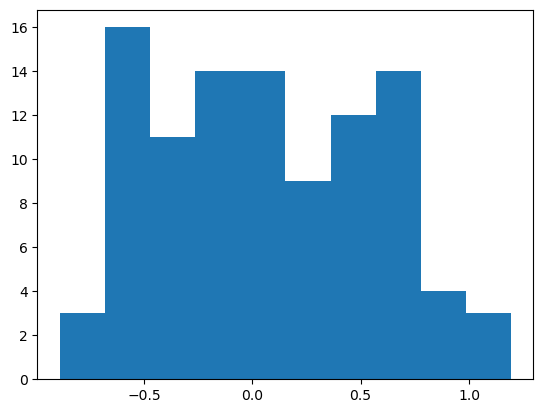

In [25]:
plt.hist(model.gates.hyper_dense_layers[0].weight.detach().cpu().numpy()[:,0])
# model.gates.hyper_dense_layers[0].weight.shape

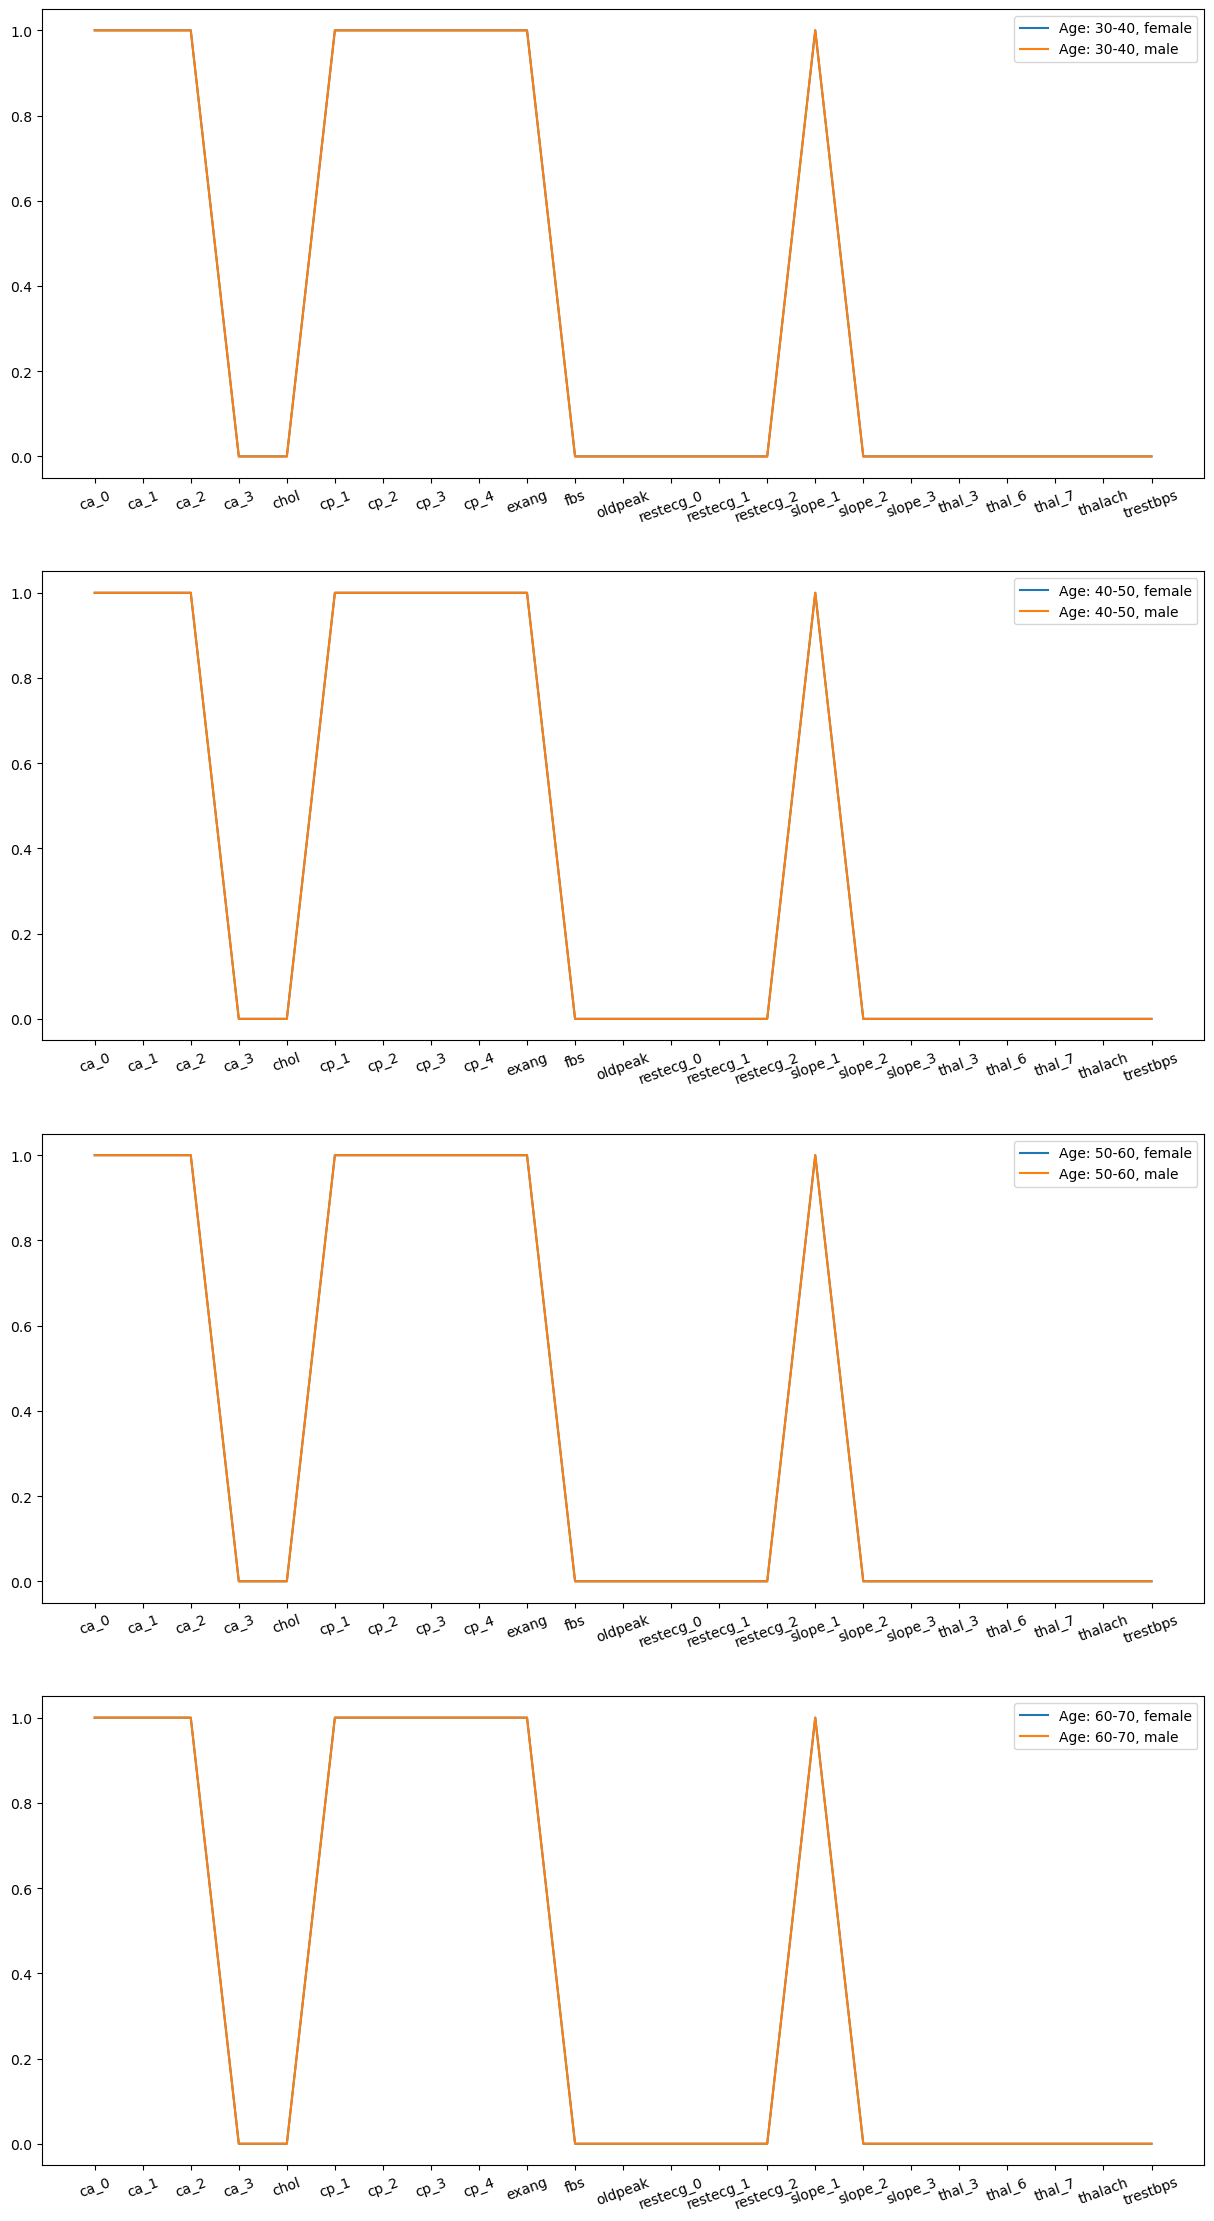

In [24]:
# output.shape,target.shape
# age_min,age_max
plots_fname = plots_folder+"/epoch_{}.png".format(epoch)
plots_fname
get_feature_importance_plots(model,plots_fname,show_fig=True)

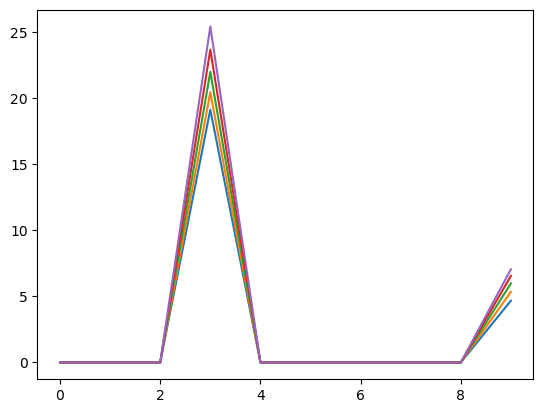

In [28]:
num_samples = 5
# age = np.random.uniform(30,40,size=(num_samples,1))
age = np.array([30,40,50,60,70]).reshape((-1,1))
age = (age-age_min)/(age_max-age_min)
sex = np.ones((num_samples,1))#1-male, 0-female
B = np.hstack((age,sex))
B = torch.tensor(B).to(gpu).float()

hyper_dense_layers = model.gates.hyper_dense_layers
mu = B
for i,dense in enumerate(hyper_dense_layers):
    if i<4:
        mu = dense(mu)
    
# mu = model.gates.get_feature_importance(B)
mu = mu.detach().cpu().numpy()
for i in range(mu.shape[0]):
    plt.plot(mu[i])
# plt.plot(np.mean(mu,axis=0))

In [23]:
def get_feature_importance_plots(model,plots_fname,show_fig=False):
    
    def get_B(age,sex):
        return np.hstack((age,1-sex))
#         return np.hstack((age,sex,1-sex))
        
    num_samples = 100
    age = np.random.uniform(30,40,size=(num_samples,1))
    age = (age-age_min)/(age_max-age_min)
    sex = np.ones((num_samples,1))#1-male, 0-female
    B = get_B(age,sex)
#     B = np.hstack((age,sex,1-sex))
    B = torch.tensor(B).to(gpu).float()
    mu = model.gates.get_feature_importance(B)
    mu = mu.detach().cpu().numpy()
    fig = plt.figure(figsize=(15,7*4))

    plt.subplot(4,1,1)
    plt.plot(np.mean(mu,axis=0),label="Age: 30-40, female")

    num_samples = 100
    age = np.random.uniform(30,40,size=(num_samples,1))
    age = (age-age_min)/(age_max-age_min)
    sex = np.zeros((num_samples,1))#1-male, 0-female
    B = get_B(age,sex)
#     B = np.hstack((age,sex,1-sex))
    B = torch.tensor(B).to(gpu).float()
    mu = model.gates.get_feature_importance(B)
    mu = mu.detach().cpu().numpy()
    plt.plot(np.mean(mu,axis=0),label="Age: 30-40, male")
    labels = input_cols
    plt.xticks(ticks=np.arange(len(labels)),labels=input_cols,rotation=20)
    plt.legend()
    # plt.show()
    plt.legend()
    # plt.figure(figsize=(15,7))
    plt.subplot(4,1,2)
    num_samples = 100
    age = np.random.uniform(40,50,size=(num_samples,1))
    age = (age-age_min)/(age_max-age_min)
    sex = np.ones((num_samples,1))#1-male, 0-female
    B = get_B(age,sex)
#     B = np.hstack((age,sex,1-sex))
    B = torch.tensor(B).to(gpu).float()
    mu = model.gates.get_feature_importance(B)
    mu = mu.detach().cpu().numpy()
    plt.plot(np.mean(mu,axis=0),label="Age: 40-50, female")


    num_samples = 100
    age = np.random.uniform(40,50,size=(num_samples,1))
    age = (age-age_min)/(age_max-age_min)
    sex = np.zeros((num_samples,1))#1-male, 0-female
    B = get_B(age,sex)
#     B = np.hstack((age,sex,1-sex))
    B = torch.tensor(B).to(gpu).float()
    mu = model.gates.get_feature_importance(B)
    mu = mu.detach().cpu().numpy()
    plt.plot(np.mean(mu,axis=0),label="Age: 40-50, male")
    labels = input_cols
    plt.xticks(ticks=np.arange(len(labels)),labels=input_cols,rotation=20)
    plt.legend()
    # plt.show()
    plt.legend()
    # plt.figure(figsize=(15,7))
    plt.subplot(4,1,3)
    num_samples = 100
    age = np.random.uniform(50,60,size=(num_samples,1))
    age = (age-age_min)/(age_max-age_min)
    sex = np.ones((num_samples,1))#1-male, 0-female
    B = get_B(age,sex)
#     B = np.hstack((age,sex,1-sex))
    B = torch.tensor(B).to(gpu).float()
    mu = model.gates.get_feature_importance(B)
    mu = mu.detach().cpu().numpy()
    plt.plot(np.mean(mu,axis=0),label="Age: 50-60, female")


    num_samples = 100
    age = np.random.uniform(50,60,size=(num_samples,1))
    age = (age-age_min)/(age_max-age_min)
    sex = np.zeros((num_samples,1))#1-male, 0-female
    B = get_B(age,sex)
#     B = np.hstack((age,sex,1-sex))
    B = torch.tensor(B).to(gpu).float()
    mu = model.gates.get_feature_importance(B)
    mu = mu.detach().cpu().numpy()
    plt.plot(np.mean(mu,axis=0),label="Age: 50-60, male")

    labels = input_cols
    plt.xticks(ticks=np.arange(len(labels)),labels=input_cols,rotation=20)
    plt.legend()
#     plt.show()

    # plt.figure(figsize=(15,7))
    plt.legend()
    plt.subplot(4,1,4)
    num_samples = 100
    age = np.random.uniform(60,70,size=(num_samples,1))
    age = (age-age_min)/(age_max-age_min)
    sex = np.ones((num_samples,1))#1-male, 0-female
    B = get_B(age,sex)
#     B = np.hstack((age,sex,1-sex))
    B = torch.tensor(B).to(gpu).float()
    mu = model.gates.get_feature_importance(B)
    mu = mu.detach().cpu().numpy()
    plt.plot(np.mean(mu,axis=0),label="Age: 60-70, female")


    num_samples = 100
    age = np.random.uniform(60,70,size=(num_samples,1))
    age = (age-age_min)/(age_max-age_min)
    sex = np.zeros((num_samples,1))#1-male, 0-female
    B = get_B(age,sex)
#     B = np.hstack((age,sex,1-sex))
    B = torch.tensor(B).to(gpu).float()
    mu = model.gates.get_feature_importance(B)
    mu = mu.detach().cpu().numpy()
    plt.plot(np.mean(mu,axis=0),label="Age: 60-70, male")

    labels = input_cols
    plt.xticks(ticks=np.arange(len(labels)),labels=input_cols,rotation=20)
    plt.legend()
    plt.savefig(plots_fname)
    if not show_fig:
        plt.close(fig)
    
#     plt.show()

In [31]:
plt.xticks?

(25,)

train_acc:77.64, test_acc:70.00


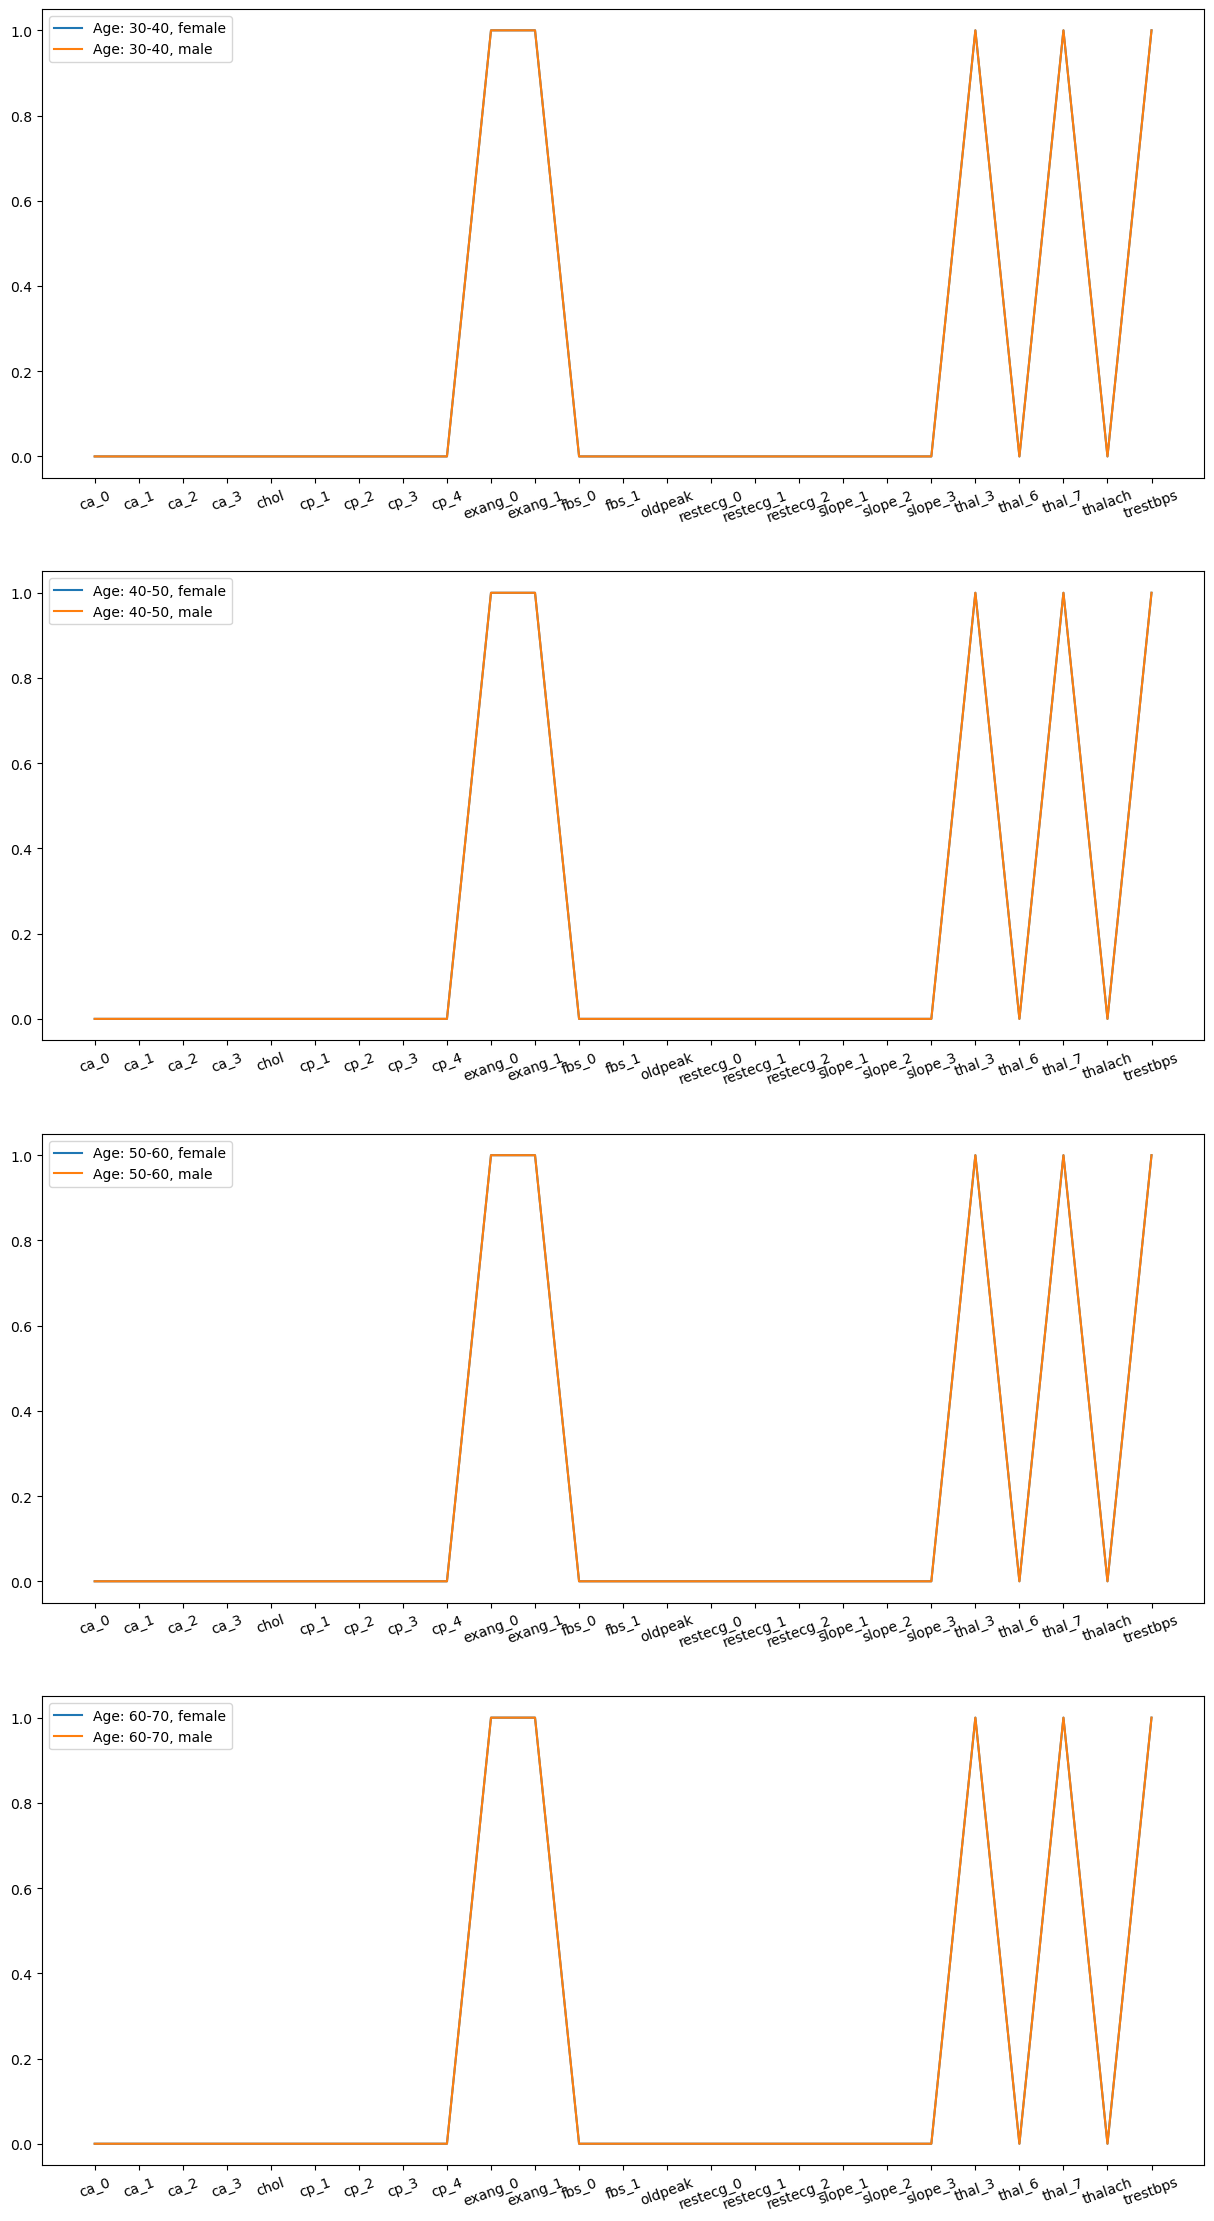

In [15]:
ML_model_name = "fc_stg_layered_param_modular_model"#"fc_stg_layered_param_linear_model"#"fc_stg_layered_param_model"#"fc_stg_param_model"



learning_rate = 5e-1
stg_regularizer = 1e-1 #1e-2
hidden_dims = [10]
hyper_hidden_dim = [100]

epochs = 100
dropout = 0

add_name = ""
add_name += "_"+"_".join(np.array([input_dim]+hidden_dims+[output_dim]).astype(str))
add_name += "_hyper_"+"_".join(np.array([param_dim]+hyper_hidden_dim+[input_dim]).astype(str))

root_fname = "./Trained_Model_heartdisease" #/data2/rsristi/FeatureSelection
if not os.path.exists(root_fname):
    os.mkdir(root_fname)

model_path = "{}/{}_lr_{}_stg_lr_{}{}.model".format(root_fname,ML_model_name,str(learning_rate).replace(".", "_"),str(stg_regularizer).replace(".","_"),add_name)

# model_path = "fc_stg_layered_param_modular_model_lr_0_0001_stg_lr_0_0001_25_10_1_hyper_3_100_25.model"

loss_path = model_path.replace("model","mat")
plots_folder = model_path.replace(".model","")
if not os.path.exists(plots_folder):
    os.mkdir(plots_folder)

gpu = torch.device('cuda:2')

criterion = nn.BCELoss() 

model = models.__dict__[ML_model_name](input_dim, hidden_dims, output_dim, param_dim, hyper_hidden_dim, dropout)
model = model.to(gpu).float()
model.load_state_dict(torch.load(model_path))
model.eval()

train_loss = 0
test_loss = 0

train_count = 0
test_count = 0
train_acc_batch = []
for batch, (input, target, B) in enumerate(train_dataloader):
    input = input.to(gpu).float()
    target = target.to(gpu).float()
    B = B.to(gpu).float()
#         B = B.to(gpu).int()/rotations[1]
#         B = F.one_hot((B).to(int),num_classes=num_rot).float()
    output = model(input,B)
    output = torch.squeeze(output)
    train_acc_batch.append(accuracy_score((output>0.5).float().detach().cpu().numpy(), target.detach().cpu().numpy()))

    loss = criterion(output, torch.squeeze(target))
    stg_loss = torch.mean(model.reg((model.gates.mu + 0.5)/model.sigma)) 
    #                 weights = model.lstm.weight_ih_l0
#                 l1_loss = torch.sum(torch.abs(weights))
#                 loss +=  l1_regularizer*l1_loss
    loss += stg_regularizer*stg_loss
#                 loss += model.l0_reg
    train_loss += loss.item()
    train_count += len(input)
train_acc = np.mean(train_acc_batch)*100


test_acc_batch = []
for batch, (input, target, B) in enumerate(test_dataloader):
    input = input.to(gpu).float()
    target = target.to(gpu).float()
    B = B.to(gpu).float()
#         B = B.to(gpu).int()/rotations[1]
#         B = F.one_hot((B).to(int),num_classes=num_rot).float()
    output = model(input,B)
    output = torch.squeeze(output)

    test_acc_batch.append(accuracy_score((output>0.5).float().detach().cpu().numpy(), target.detach().cpu().numpy()))
    loss = criterion(output, torch.squeeze(target))
    stg_loss = torch.mean(model.reg((model.gates.mu + 0.5)/model.sigma)) 
#                 weights = model.lstm.weight_ih_l0
#                 l1_loss = torch.sum(torch.abs(weights))
#                 loss +=  l1_regularizer*l1_loss
    loss += stg_regularizer*stg_loss
#                 loss += model.l0_reg
    test_loss += loss.item()
    test_count += len(input)
test_acc = np.mean(test_acc_batch)*100

print("train_acc:{:.2f}, test_acc:{:.2f}".format(train_acc,test_acc))

get_feature_importance_plots(model)

In [18]:
B

tensor([[0.6042, 0.0000, 1.0000],
        [0.3958, 0.0000, 1.0000],
        [0.7083, 0.0000, 1.0000],
        [0.4375, 0.0000, 1.0000],
        [0.7708, 0.0000, 1.0000],
        [0.5208, 0.0000, 1.0000],
        [0.5625, 0.0000, 1.0000],
        [0.3125, 0.0000, 1.0000],
        [0.5625, 0.0000, 1.0000],
        [0.2500, 0.0000, 1.0000],
        [0.3750, 0.0000, 1.0000],
        [0.7500, 1.0000, 0.0000],
        [0.7917, 0.0000, 1.0000],
        [0.2917, 1.0000, 0.0000],
        [0.5208, 0.0000, 1.0000],
        [0.5833, 1.0000, 0.0000],
        [0.4792, 0.0000, 1.0000],
        [0.3125, 1.0000, 0.0000],
        [0.2292, 0.0000, 1.0000],
        [0.6042, 0.0000, 1.0000],
        [0.1250, 0.0000, 1.0000],
        [0.4375, 1.0000, 0.0000],
        [0.4583, 0.0000, 1.0000],
        [0.3958, 0.0000, 1.0000],
        [0.2500, 0.0000, 1.0000],
        [0.2708, 0.0000, 1.0000],
        [0.4167, 1.0000, 0.0000],
        [0.7500, 0.0000, 1.0000],
        [0.4583, 0.0000, 1.0000],
        [0.854

In [5]:
gpu = torch.device('cuda:2')
for batch, (input, target, B) in enumerate(test_dataloader):
        input = input.to(gpu).float()
        target = target.to(gpu).float()
        B = B.to(gpu).float()
        print(input.shape,target.shape,B.shape)

torch.Size([60, 25]) torch.Size([60, 1]) torch.Size([60, 3])


In [77]:
# Define dataloaders for train and test datasets


array(['ca_0', 'ca_1', 'ca_2', 'ca_3', 'chol', 'cp_1', 'cp_2', 'cp_3',
       'cp_4', 'exang_0', 'exang_1', 'fbs_0', 'fbs_1', 'oldpeak',
       'restecg_0', 'restecg_1', 'restecg_2', 'slope_1', 'slope_2',
       'slope_3', 'thal_3', 'thal_6', 'thal_7', 'thalach', 'trestbps'],
      dtype='<U9')

<Axes: >

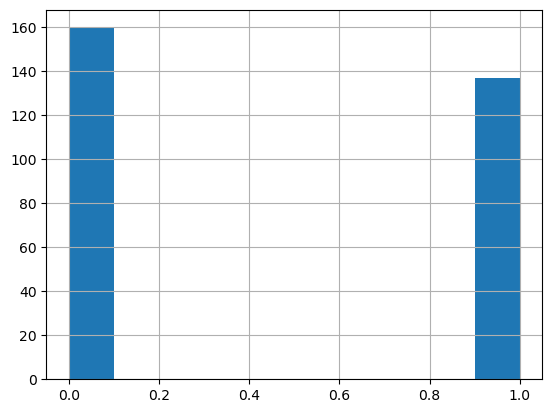

In [62]:
# data["num"].hist()
# data[cat_cols].hist(figsize=(15,15))
# data[cont_cols].hist(figsize=(15,15))

array([[<Axes: title={'center': 'sex'}>, <Axes: title={'center': 'cp'}>,
        <Axes: title={'center': 'fbs'}>],
       [<Axes: title={'center': 'restecg'}>,
        <Axes: title={'center': 'exang'}>,
        <Axes: title={'center': 'slope'}>],
       [<Axes: title={'center': 'ca'}>, <Axes: title={'center': 'thal'}>,
        <Axes: >]], dtype=object)

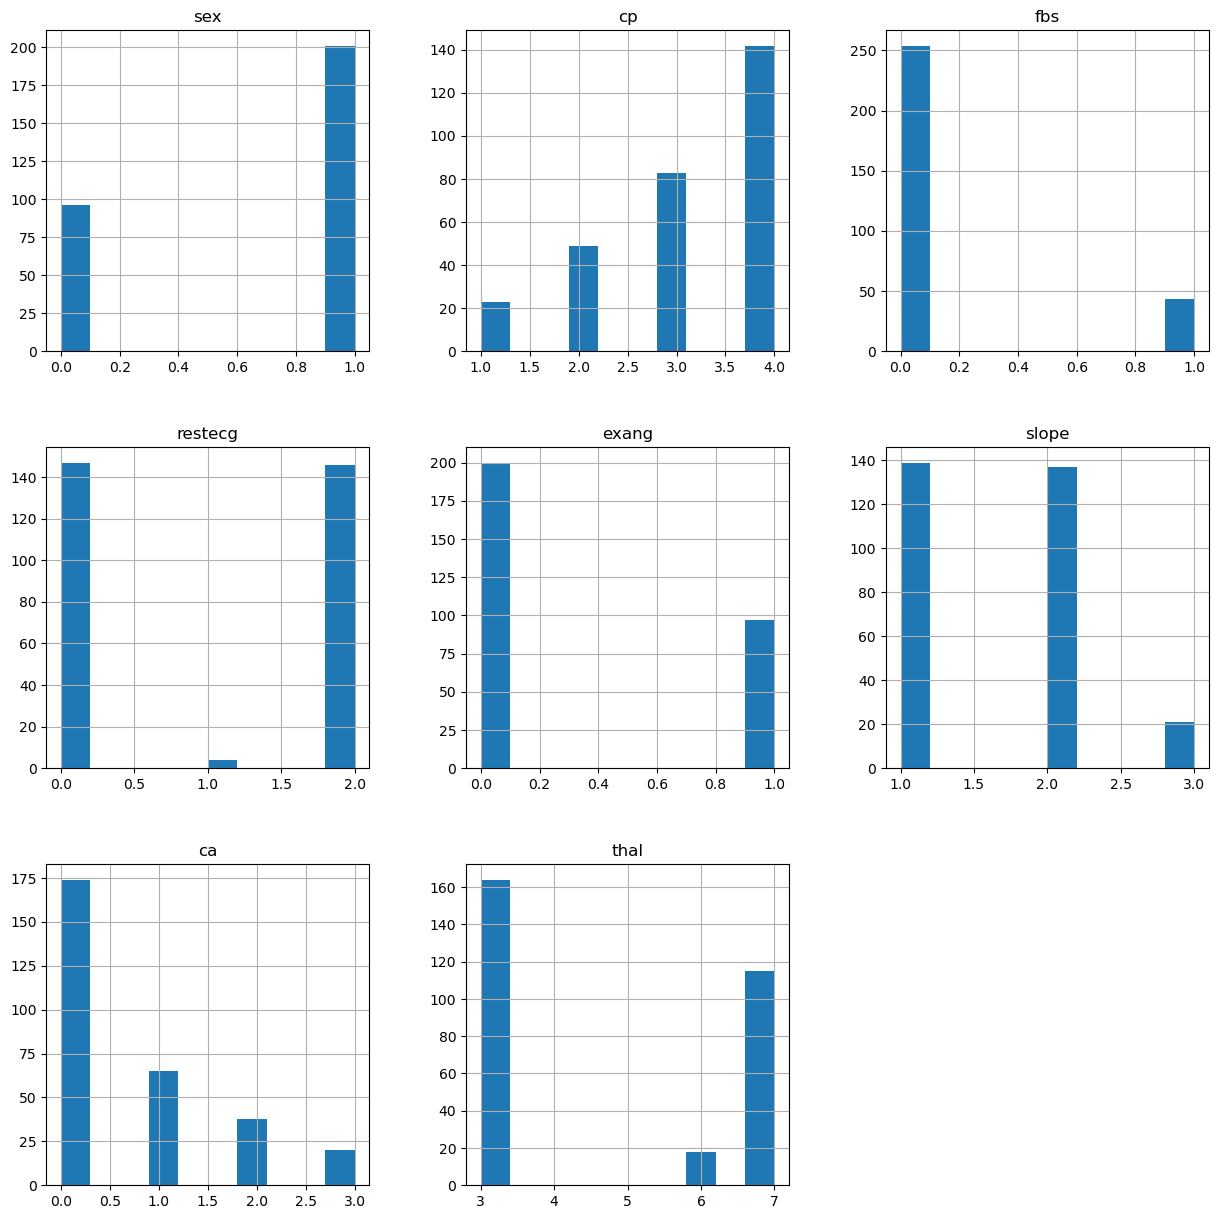

In [33]:
data[cat_cols].hist(figsize=(15,15))

array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'trestbps'}>],
       [<Axes: title={'center': 'chol'}>,
        <Axes: title={'center': 'thalach'}>],
       [<Axes: title={'center': 'oldpeak'}>, <Axes: >]], dtype=object)

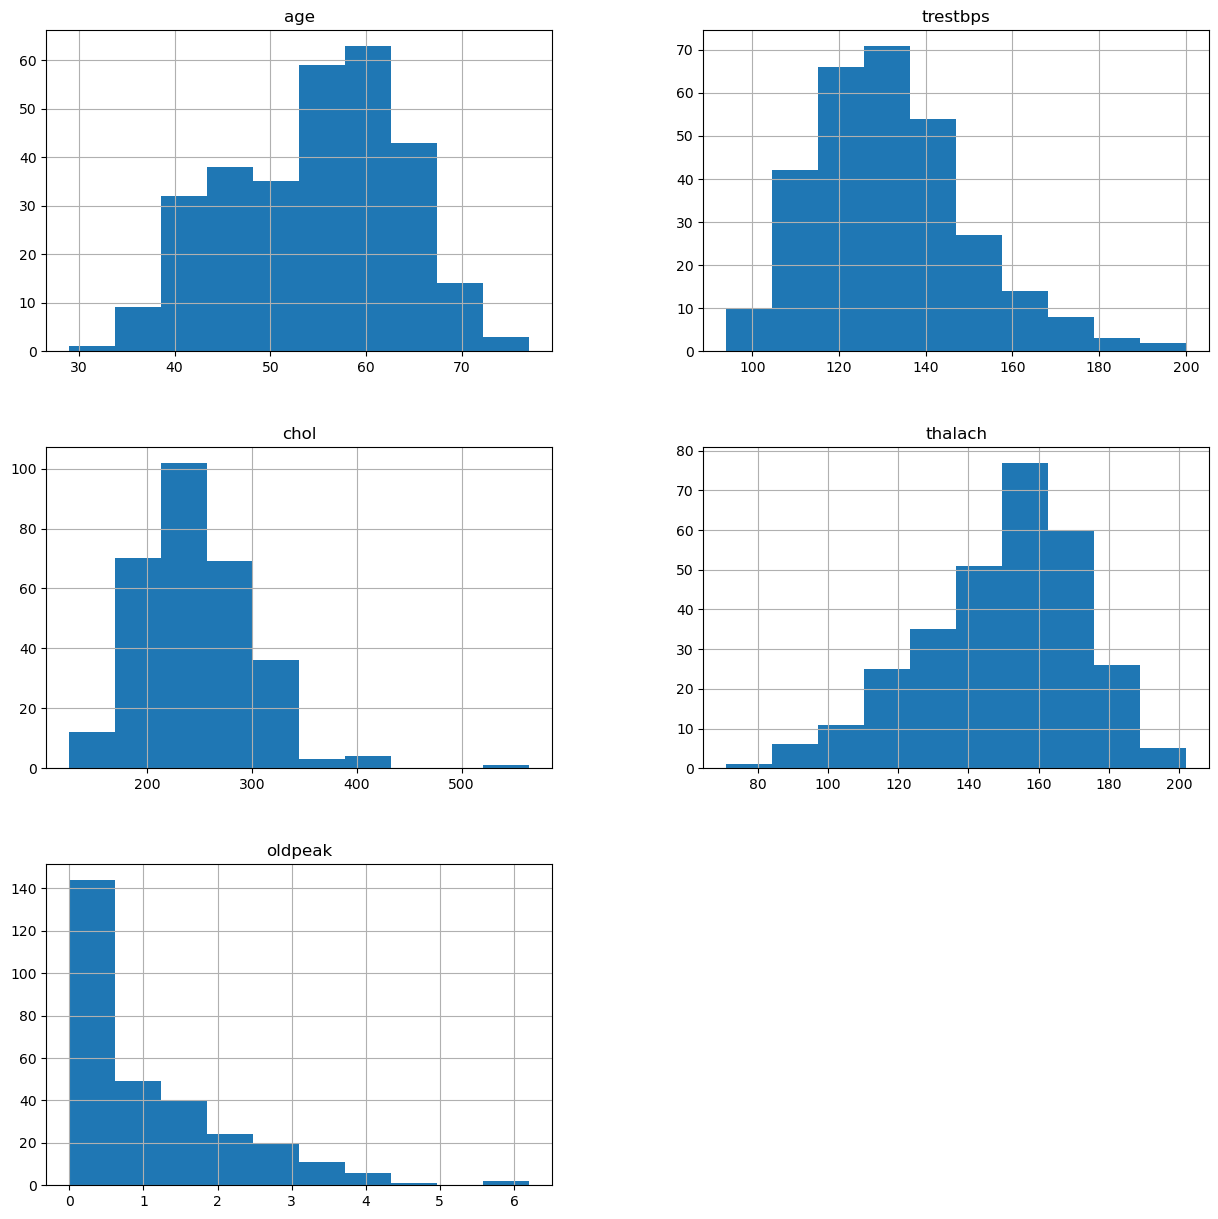

In [34]:
# fig,ax = plt.subplots()
data[cont_cols].hist(figsize=(15,15))